# Structure to structure net

Import core modules

In [2]:
import pandas as pd
import numpy as np
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder

Load previously calculated sequence to structure model

In [62]:
model = keras.models.load_model('/homes/2472402/data/layer1.model/')

Load training data as 1 dataframe per sequence

In [63]:
data = pickle.load(open('/homes/2472402/data/linearized_train_sequences.pkl', 'rb'))

Separate predictions from dssp

In [67]:
data[0].head()

,A,R,N,D,C,Q,E,G,H,I,...,K,M,F,P,S,T,W,Y,V,dssp
,0,0,0,0,0,0,0,0,0,0,...,16,16,16,16,16,16,16,16,16,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.119203,0.952574,0.268941,0.268941,0.268941,0.119203,0.017986,0.047426,0.952574,-
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.993307,0.047426,0.017986,0.017986,0.268941,0.047426,0.731059,0.731059,0.017986,-
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.268941,0.017986,0.119203,0.017986,0.119203,0.047426,0.017986,0.731059,0.006693,-
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.017986,0.268941,0.119203,0.017986,0.017986,0.268941,0.006693,0.047426,0.982014,-
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.268941,0.268941,0.047426,0.017986,0.119203,0.952574,0.006693,0.047426,0.952574,-


In [68]:
y_actual = [df.dssp for df in data]
X = [df.iloc[:,:-1] for df in data]

Make predictions with training data

In [72]:
Y = [model.predict(Xi) for Xi in X]

Save predictions made by layer 1 along with ground truths

In [3]:
pickle.dump([Y, y_actual], open('/homes/2472402/data/layer.1.predictions.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'Y' is not defined

# Load data and do one hot encoding of actual dssp info

In [4]:
[Y_pred, Y_actual] = pickle.load(open('/homes/2472402/data/layer.1.predictions.pkl', 'rb'))
 
# convert prediction to actual predictions

Perform one hot encoding of y_actual in same column order as that defined in one hot encoding of layer 1 labels

In [75]:
enc = OneHotEncoder(handle_unknown='ignore', categories = [['H','E','-']], sparse=False)

def one_hot(y,enc):
    y_as_col = y.values.reshape(-1,1)
    y_one_hot = pd.DataFrame(enc.fit_transform(y_as_col))
    return y_one_hot

Y_actual = [one_hot(y_actual,enc) for y_actual in Y_actual]

Generate sliding window and convert to 1 row df for every sequence

In [77]:
# function to add padding of #FLANK rows to the top and bottom of dataframe. flank = 8 for layer 1 (seq to struct) and flank = 9 for layer 2 (struct to struct)
def padding_operation(pred, flank):
    # create a numpy array with 21 NaNs
    pad_np_array = np.hstack((np.repeat(np.nan,3)))
    # convert numpy array into pd Series so we can create dataframe based on it
    pad_row = pd.Series(pad_np_array)
    # create empty dataframe and add the NaN rows to it
    pad_df = pd.DataFrame()
    for _ in range(flank):
        pad_df = pad_df.append(pad_row, ignore_index=True)
    # create a copy of profile which i will now modify
    df = pd.DataFrame(pred)
    # add padding to above and below dataframes
    padded_df = pd.concat([pad_df, df, pad_df], ignore_index=True)
    return padded_df

# function returns a list of windows (variable name patterns). flank argument is same as above. takes in the padded_df from padding_operation()
def sliding_operation(padded_df, flank):
    # Using iloc based indexing. i.e. 'location based indexing' cf label based indexing
    # idx of first amino acid of sequence in padded dataframe 
    seqStartIdx = flank 
    # idx of last amino acid of sequence in padded dataframe
    seqEndIdx = padded_df.shape[0]-flank
    # create a list of dataframes which we will put individual windows into. this list of patterns should span across samples
    patterns = []
    for seqIdx in range(seqStartIdx, seqEndIdx): # for each amino acid sequence / centroid of window
        # define start and end index of window given position of center residue
        winStartIdx = seqIdx - flank
        winEndIdx = seqIdx + flank + 1
        # again using location based indexing with .iloc[]
        pattern = padded_df.iloc[winStartIdx:winEndIdx, :]
        patterns.append(pattern)
    return patterns

# function to collapse rows in df into a single row dataframe. 
def linearize(df):
    ndf = df.T.unstack().to_frame().T
    ndf.columns = list(range(len(ndf.columns))) # do this so as to avoid having to rename columns later on
    return ndf

Wrapper code calling two functions above on each PSSM dataframe to generate patterns from all dataframes
THIS CODE IS TIME CONSUMING

In [82]:
%%time

# keep patterns in their sequencse. list of dataframes of linearized 3 state predictions
Y_patterns = []
for y_pred in Y_pred:
    padded_pf = padding_operation(y_pred, flank = 9)
    patterns = sliding_operation(padded_pf, flank = 9)
    linearized_patterns = [linearize(pattern) for pattern in patterns]
    df = pd.concat(linearized_patterns, ignore_index=True)
    Y_patterns.append(df)

len(Y_patterns)

KeyboardInterrupt: 

Save as input for layer 2

In [79]:
pickle.dump([Y_patterns,Y_actual], open('/homes/2472402/data/layer2.input.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

# Load input for layer 2 and train network

In [5]:
# calling it Y_patterns because Y_pred is a different thing (see above)
[Y_patterns,Y_actual] = pickle.load(open('/homes/2472402/data/layer2.input.pkl', 'rb'))

Option 1 of 2: Run this code if removing rows with NaN (do not run this)

In [85]:
idx = [np.logical_not(y.isnull().any(axis=1)) for y in Y_patterns]
X_ls = [y.loc[i] for (y, i) in zip(Y_patterns, idx)]
X_in = pd.concat(X_ls, axis='rows')
Y_ls = [y.loc[i] for (y, i) in zip(Y_actual, idx)]
Y_in = pd.concat(Y_ls, axis='rows')
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_in, Y_in, train_size = 10000, test_size = 2000, random_state = 0)

### Option 2 of 2: Run this block if filling NaN with 0

In [6]:
X = pd.concat(Y_patterns, axis='rows')
# replace nan with 0
X.fillna(0, inplace=True)
Y = pd.concat(Y_actual, axis='rows')
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size = 6000, test_size = 1000, random_state = 0)

Write the second layer of networks

INFO:tensorflow:Assets written to: /homes/2472402/data/layer2.model/assets
Minimum validation loss: 0.6638691425323486


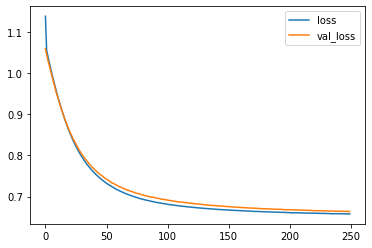

In [9]:
# define a simple model for sequence to structure prediction
model2 = keras.Sequential([
    layers.Dense(units=100, activation='sigmoid', input_shape=[57]),
    layers.Dense(units=3, activation='softmax')
])

# compile mode. note metrics argument is left out
model2.compile(
    optimizer='sgd', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model2.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=128, # not optimised
    epochs=250, # same as jnet v2.3.1
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)

model2.save('/homes/2472402/data/layer2.model')

# review results
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))